In [293]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import itertools
from pylab import rcParams
import warnings
warnings.filterwarnings('ignore')

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import kpss, adfuller
from statsmodels.tsa.arima.model import ARIMA
from tabulate import tabulate

sns.set_style('darkgrid')

In [128]:
def calculate_mae(y_true, y_pred):
    assert len(y_true) == len(y_pred), 'unequal length arrays passed'
    if type(y_true) != np.ndarray:
        y_true = np.array(y_true)
    if type(y_pred) != np.ndarray:
        y_pred = np.array(y_pred)
    return np.mean(np.abs(y_true - y_pred))

def calculate_rmse(y_true, y_pred):
    assert len(y_true) == len(y_pred), 'unequal length arrays passed'
    if type(y_true) != np.ndarray:
        y_true = np.array(y_true)
    if type(y_pred) != np.ndarray:
        y_pred = np.array(y_pred)
    return np.sqrt(np.mean((y_true - y_pred)**2))

def calculate_mape(y_true, y_pred):
    assert len(y_true) == len(y_pred), 'unequal length arrays passed'
    indices = np.where(y_true == 0)[0]
    y_true, y_pred = y_true[~indices], y_pred[~indices]
    if type(y_true) != np.ndarray:
        y_true = np.array(y_true)
    if type(y_pred) != np.ndarray:
        y_pred = np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred)/y_true)) * 100

In [129]:
def acfplot(y):
    rcParams['figure.figsize'] = 12, 5
    plot_acf(y, lags=20)
    plt.xticks(range(0, 20), range(1, 21))
    rcParams['figure.figsize'] = 6.4, 4.8
    plt.show()

In [130]:
def pacfplot(y):
    rcParams['figure.figsize'] = 12, 5
    plot_pacf(y, lags=20)
    plt.xticks(range(0, 20), range(1, 21))
    rcParams['figure.figsize'] = 6.4, 4.8
    plt.show()

In [131]:
def get_error_metrics(y_true, y_pred):
    error_dict = {}
    assert len(y_true) == len(y_pred), 'unequal length arrays passed'
    error_dict['mean_absolute_error'] = calculate_mae(y_true, y_pred)
    error_dict['root_mean_squared_error'] = calculate_rmse(y_true, y_pred)
    error_dict['mean_absolute_percentage_error'] = calculate_mape(y_true, y_pred)
    print(tabulate(error_dict.items(), tablefmt='grid'))    

In [4]:
df = pd.read_csv("../data/train.csv")
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [6]:
df.Date = pd.to_datetime(df.Date)

In [7]:
df.StateHoliday.value_counts()

0    855087
0    131072
a     20260
b      6690
c      4100
Name: StateHoliday, dtype: int64

In [8]:
df[df.StateHoliday == 0].shape

(131072, 9)

In [9]:
df.StateHoliday = df.StateHoliday.apply(lambda x: '0' if x==0 else x)
df.StateHoliday = df.StateHoliday.astype('category')
df.Sales = df.Sales.astype(np.float32)

In [10]:
df[df.StateHoliday == 0].shape

(0, 9)

In [11]:
df.StateHoliday.value_counts()

0    986159
a     20260
b      6690
c      4100
Name: StateHoliday, dtype: int64

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Store          1017209 non-null  int64         
 1   DayOfWeek      1017209 non-null  int64         
 2   Date           1017209 non-null  datetime64[ns]
 3   Sales          1017209 non-null  float32       
 4   Customers      1017209 non-null  int64         
 5   Open           1017209 non-null  int64         
 6   Promo          1017209 non-null  int64         
 7   StateHoliday   1017209 non-null  category      
 8   SchoolHoliday  1017209 non-null  int64         
dtypes: category(1), datetime64[ns](1), float32(1), int64(6)
memory usage: 59.2 MB


In [13]:
df[df.Sales == 0].describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,172871.000000,172871.000000,172871.0,172871.000000,172871.000000,172871.000000,172871.00000
mean,558.470524,6.332948,0.0,0.000046,0.000312,0.064817,0.10572
std,322.776536,1.548315,0.0,0.014024,0.017671,0.246204,0.30748
min,1.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.00000
25%,279.000000,7.000000,0.0,0.000000,0.000000,0.000000,0.00000
50%,560.000000,7.000000,0.0,0.000000,0.000000,0.000000,0.00000
75%,839.000000,7.000000,0.0,0.000000,0.000000,0.000000,0.00000
max,1115.000000,7.000000,0.0,5.000000,1.000000,1.000000,1.00000


In [14]:
store_1 = df[df.Store == 1]

In [15]:
store_1.sort_values('Date', inplace=True)

# category encoding

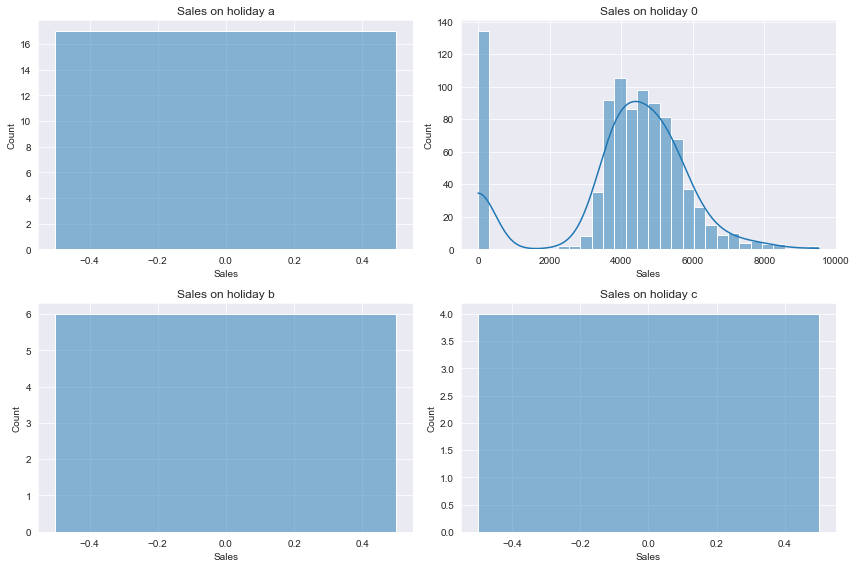

In [16]:
plot = 1
plt.figure(figsize=(12, 8))
for holiday in store_1.StateHoliday.unique():
    plt.subplot(2, 2, plot)
    plot += 1
    sns.histplot(store_1[store_1.StateHoliday == holiday].Sales, kde=True)
    plt.title("Sales on holiday "+holiday)
plt.tight_layout()
plt.show()

In [17]:
state_holiday_dummies = pd.get_dummies(store_1.StateHoliday, drop_first=True, prefix='stateholiday')
store_1 = pd.concat([store_1, state_holiday_dummies], axis=1)
store_1.drop('StateHoliday', axis=1, inplace=True)

In [18]:
store_1

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,SchoolHoliday,stateholiday_a,stateholiday_b,stateholiday_c
1016095,1,2,2013-01-01,0.0,0,0,0,1,1,0,0
1014980,1,3,2013-01-02,5530.0,668,1,0,1,0,0,0
1013865,1,4,2013-01-03,4327.0,578,1,0,1,0,0,0
1012750,1,5,2013-01-04,4486.0,619,1,0,1,0,0,0
1011635,1,6,2013-01-05,4997.0,635,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
4460,1,1,2015-07-27,6102.0,612,1,1,1,0,0,0
3345,1,2,2015-07-28,5011.0,560,1,1,1,0,0,0
2230,1,3,2015-07-29,4782.0,523,1,1,1,0,0,0
1115,1,4,2015-07-30,5020.0,546,1,1,1,0,0,0


In [19]:
store_1.reset_index(drop=True, inplace=True)

In [20]:
store_1['month'] = store_1.Date.dt.month
store_1['year'] = store_1.Date.dt.year

In [21]:
store_1.drop('Store', axis=1, inplace=True)

In [22]:
store_1.head()

,DayOfWeek,Date,Sales,Customers,Open,Promo,SchoolHoliday,stateholiday_a,stateholiday_b,stateholiday_c,month,year
0,2,2013-01-01,0.0,0,0,0,1,1,0,0,1,2013
1,3,2013-01-02,5530.0,668,1,0,1,0,0,0,1,2013
2,4,2013-01-03,4327.0,578,1,0,1,0,0,0,1,2013
3,5,2013-01-04,4486.0,619,1,0,1,0,0,0,1,2013
4,6,2013-01-05,4997.0,635,1,0,1,0,0,0,1,2013


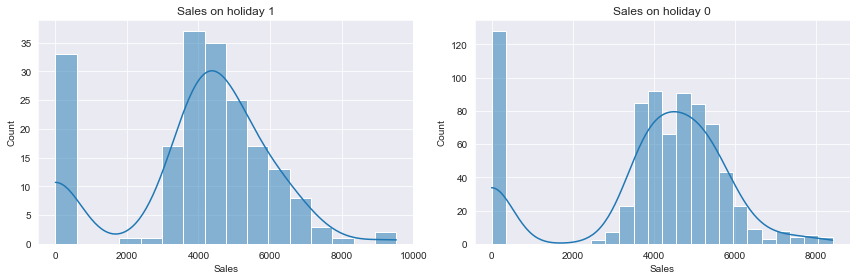

In [23]:
plot = 1
plt.figure(figsize=(12, 4))
for holiday in store_1.SchoolHoliday.unique():
    plt.subplot(1, 2, plot)
    plot += 1
    sns.histplot(store_1[store_1.SchoolHoliday == holiday].Sales, kde=True)
    plt.title("Sales on holiday "+ str(holiday))
plt.tight_layout()
plt.show()

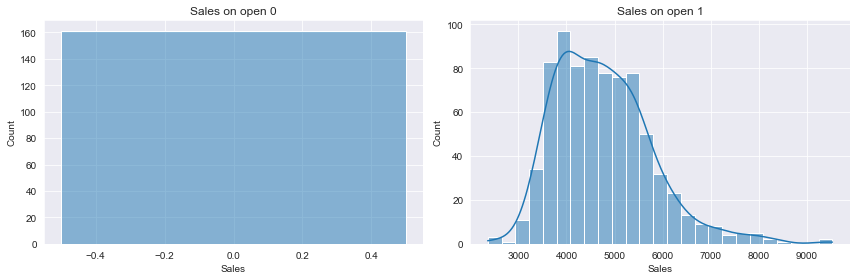

In [24]:
plot = 1
plt.figure(figsize=(12, 4))
for open in store_1.Open.unique():
    plt.subplot(1, 2, plot)
    plot += 1
    sns.histplot(store_1[store_1.Open == open].Sales, kde=True)
    plt.title("Sales on open "+ str(open))
plt.tight_layout()
plt.show()

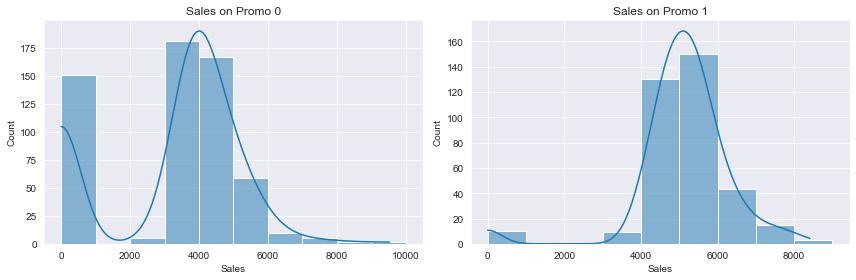

In [25]:
plot = 1
plt.figure(figsize=(12, 4))
for Promo in store_1.Promo.unique():
    plt.subplot(1, 2, plot)
    plot += 1
    sns.histplot(store_1[store_1.Promo == Promo].Sales, kde=True, binwidth=1000)
    plt.title("Sales on Promo "+ str(Promo))
plt.tight_layout()
plt.show()

<AxesSubplot:xlabel='Customers', ylabel='Sales'>

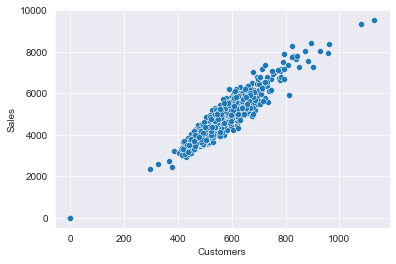

In [26]:
sns.scatterplot(data=store_1, x='Customers', y='Sales')

# Stationarity Tests

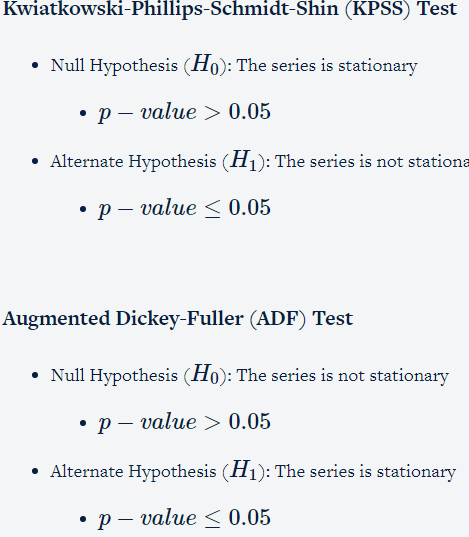

Case 1: Both tests conclude that the series is not stationary - The series is not stationary
<br>Case 2: Both tests conclude that the series is stationary - The series is stationary
<br>Case 3: KPSS indicates stationarity and ADF indicates non-stationarity - The series is trend stationary. Trend needs to be removed to make series strict stationary. The detrended series is checked for stationarity.
<br>Case 4: KPSS indicates non-stationarity and ADF indicates stationarity - The series is difference stationary. Differencing is to be used to make series stationary. The differenced series is checked for stationarity.

In [27]:
def run_adf_test(y):
    result = adfuller(y)
    adf_results = {}
    adf_results['adf'] = result[0]
    adf_results['pvalue'] = result[1]
    adf_results['usedlag'] = result[2]
    adf_results['nobs'] = result[3]
    adf_results['critical'] = result[4]
    adf_results['icbest'] = result[5]
    print(tabulate(adf_results.items(), tablefmt='grid'))

In [28]:
def run_kpss_test(y):
    result = kpss(y)
    kpss_results = {}
    kpss_results['kpss_stat'] = result[0]
    kpss_results['p_value'] = result[1]
    kpss_results['lags'] = result[2]
    kpss_results['crit'] = result[3]
    print(tabulate(kpss_results.items(), tablefmt='grid'))

In [29]:
run_adf_test(store_1.Sales)

+----------+-----------------------------------------------------------------------------------+
| adf      | -4.368104368168503                                                                |
+----------+-----------------------------------------------------------------------------------+
| pvalue   | 0.0003378834614142389                                                             |
+----------+-----------------------------------------------------------------------------------+
| usedlag  | 21                                                                                |
+----------+-----------------------------------------------------------------------------------+
| nobs     | 920                                                                               |
+----------+-----------------------------------------------------------------------------------+
| critical | {'1%': -3.4374778690219956, '5%': -2.864686684217556, '10%': -2.5684454926748583} |
+----------+------------------

In [30]:
run_kpss_test(store_1.Sales)

+-----------+---------------------------------------------------------+
| kpss_stat | 0.26869396710694105                                     |
+-----------+---------------------------------------------------------+
| p_value   | 0.1                                                     |
+-----------+---------------------------------------------------------+
| lags      | 0                                                       |
+-----------+---------------------------------------------------------+
| crit      | {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739} |
+-----------+---------------------------------------------------------+


C:\Users\pavan\anaconda3\envs\datascience\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


# Modelling

## data split

In [31]:
test = store_1[store_1.Date >= '2015-07-01'][store_1.Date <= '2015-07-31']
train = store_1[store_1.Date < '2015-07-01']

In [245]:
train2 = train[train.Date>='2013-07-01'].reset_index(drop=True)

## arma with only endog variable

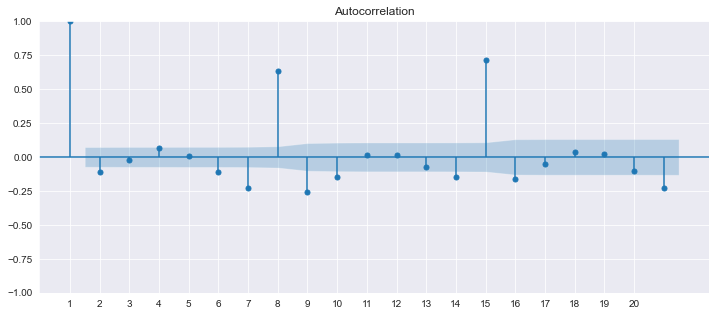

In [174]:
acfplot(train2.Sales)

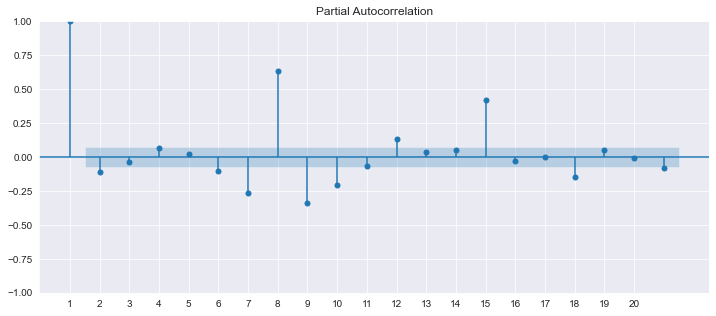

In [175]:
pacfplot(train2.Sales)

In [255]:
start_pred = train2.index.max()+1
end_pred = start_pred + 30
arma = ARIMA(train2.Sales, order=(15, 0, 15))
arma_fit = arma.fit()
y_true = test.Sales.to_numpy()
y_pred = arma_fit.predict(start=start_pred, end=end_pred).to_numpy()

C:\Users\pavan\anaconda3\envs\datascience\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


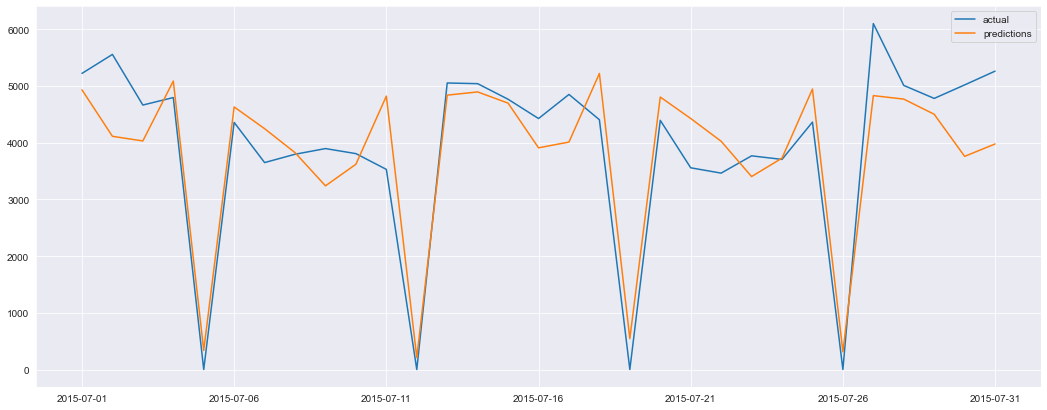

In [256]:
start = test.Date.min()
end = test.Date.max()
xticks = pd.date_range(start, end)[::5]
xticks = list(map(lambda x:x.date().strftime("%Y-%m-%d"), xticks))
plt.figure(figsize=(18, 7))
plt.plot(y_true)
plt.plot(y_pred)
plt.xticks(range(0, 31, 5), xticks)
plt.legend(labels=['actual', 'predictions'])
plt.show()

In [257]:
get_error_metrics(y_true, y_pred)

+--------------------------------+----------+
| mean_absolute_error            | 543.625  |
+--------------------------------+----------+
| root_mean_squared_error        | 676.686  |
+--------------------------------+----------+
| mean_absolute_percentage_error |  10.1694 |
+--------------------------------+----------+


# arma with exog variable

In [266]:
# train2[['Promo', 'Customers']].to_numpy()
start_pred = train2.index.max() + 1
end_pred = start_pred + 30
arma = ARIMA(train2.Sales, order=(15, 0, 15), exog=train2.Customers.to_numpy())
arma_model = arma.fit()
y_true = test.Sales.to_numpy()
y_pred = arma_model.predict(start=start_pred, end=end_pred, exog=test.Customers).to_numpy()

C:\Users\pavan\anaconda3\envs\datascience\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


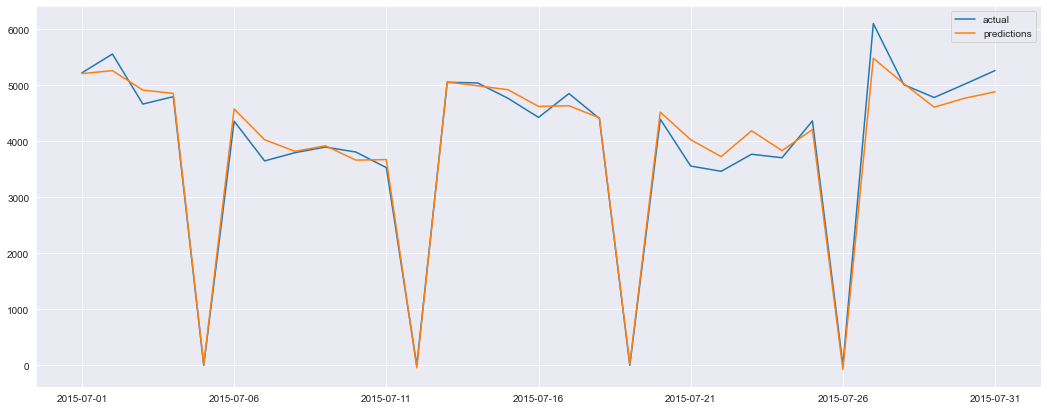

In [267]:
start = test.Date.min()
end = test.Date.max()
xticks = pd.date_range(start, end)[::5]
xticks = list(map(lambda x:x.date().strftime("%Y-%m-%d"), xticks))
plt.figure(figsize=(18, 7))
plt.plot(y_true)
plt.plot(y_pred)
plt.xticks(range(0, 31, 5), xticks)
plt.legend(labels=['actual', 'predictions'])
plt.show()

In [268]:
get_error_metrics(y_true, y_pred)

+--------------------------------+-----------+
| mean_absolute_error            | 172.277   |
+--------------------------------+-----------+
| root_mean_squared_error        | 230.704   |
+--------------------------------+-----------+
| mean_absolute_percentage_error |   4.53085 |
+--------------------------------+-----------+


## Sarima

In [288]:
start_pred = train2.index.max() + 1
end_pred = start_pred + 30
sarima = SARIMAX(train2.Sales, order=(15, 0, 15), exog=train2.Customers)
sarima_fit = sarima.fit()
y_true = test.Sales.to_numpy()
y_pred = sarima_fit.predict(start=start_pred, end=end_pred, exog=test.Customers.to_numpy()).to_numpy()

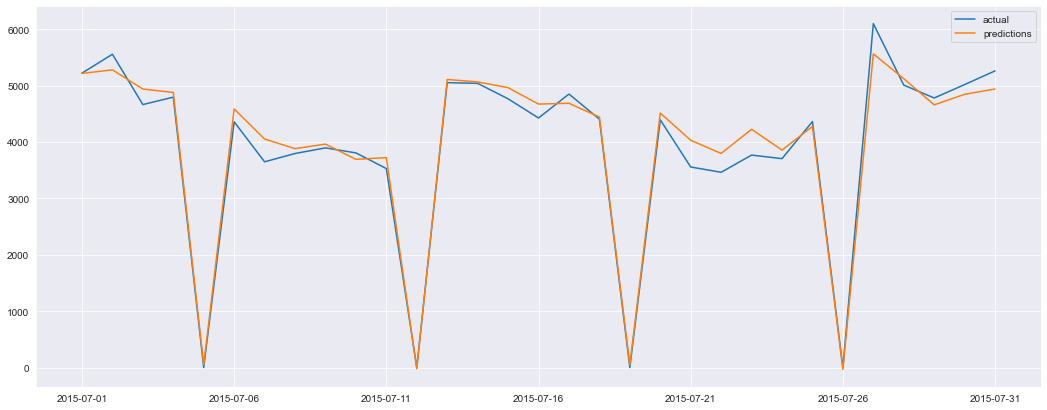

In [289]:
start = test.Date.min()
end = test.Date.max()
xticks = pd.date_range(start, end)[::5]
xticks = list(map(lambda x:x.date().strftime("%Y-%m-%d"), xticks))
plt.figure(figsize=(18, 7))
plt.plot(y_true)
plt.plot(y_pred)
plt.xticks(range(0, 31, 5), xticks)
plt.legend(labels=['actual', 'predictions'])
plt.show()

In [290]:
get_error_metrics(y_true, y_pred)

+--------------------------------+-----------+
| mean_absolute_error            | 177.684   |
+--------------------------------+-----------+
| root_mean_squared_error        | 228.396   |
+--------------------------------+-----------+
| mean_absolute_percentage_error |   4.46648 |
+--------------------------------+-----------+


## sarima with seasonal grid search

In [ ]:
start_pred = train2.index.max() + 1
end_pred = start_pred + 30

seasonal_p = [i for i in range(1, 20, 2)]
seasonal_d = [i for i in range(1, 4)]
seasonal_q = [i for i in range(0, 20, 3)]
s = [4]
seasonal_combinations = [i for  i in itertools.product(seasonal_p, seasonal_d, seasonal_q, s)]

results_df = pd.DataFrame()
for seasonal_combination in seasonal_combinations:
    try:
        sarima = SARIMAX(train2.Sales, order=(15, 0, 15),
                         exog=train2.Customers,
                         seasonal_order=seasonal_combination)
    except:
        pass
    sarima_fit = sarima.fit()
    y_pred = sarima_fit.predict(start=start_pred, end=end_pred, exog=test.Customers.to_numpy()).to_numpy()
    error_dictionary = {}
    error_dictionary['combination'] = seasonal_combination
    error_dictionary['error'] = calculate_mape(y_true, y_pred)
    results_df = results_df.append(error_dictionary, ignore_index=True)

In [310]:
results_df

,combination,error
0,"(1, 1, 0, 4)",4.466478
1,"(1, 1, 3, 4)",4.466478
2,"(1, 1, 6, 4)",4.466478
